In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import platform
import os
import multiprocessing
import datetime

%matplotlib inline

In [2]:
# consts
# number of iterations:
config = open("tester_config", "r")
times = int(config.readline()[6:-1])

# Tester results.
### Current system:

In [3]:
print "Version:", platform.platform()
print "CPU cores:", multiprocessing.cpu_count()
print "Page size:", os.sysconf('SC_PAGE_SIZE')
print "Current time:", datetime.datetime.now()

Version: Linux-3.10.0-327.el7.x86_64-x86_64-with-centos-7.2.1511-Core
CPU cores: 8
Page size: 4096
Current time: 2016-05-03 16:46:01.901726


In [4]:
data = pd.read_csv("test_result.txt", sep=' ', header=None, names=["lib", 'test', 'test_name'] + [i for i in range(times)])

In [5]:
values = [i for i in range(times)]
data["mean"] = data[values].mean(axis=1)
data["std"]  = data[values].std(axis=1)
data["testid"] = data["test"] + "_" + data["test_name"]
data = data.reindex_axis(sorted(data.columns), axis=1)
tests = sorted(list(set(data['testid'].tolist())))
libs = sorted(list(set(data['lib'].tolist())))

In [6]:
# data

## Rankings
* **1 point ** for being in std of the best test performer,
* **0.25 point** for being in each quartile,
* **-1** for failed test,
* **-0.5** for timeout,

**BONUS**: 
* **0.5** for best std in each test
* **1** for full test passage

In [7]:
ranks = pd.DataFrame(index=libs, columns=tests).fillna(-1)
ranks['All test passed'] = np.zeros(len(libs))

datarank = data[['lib', 'testid', 'mean', 'std']]
for test in tests:
    testf = datarank[datarank.testid == test]
    best_mean = testf['mean'][testf['mean'] != -1].min()
    best_mean_std = testf[testf['mean'] == best_mean]["std"].values[0]
    
    best_std = testf['std'][testf['std'] != 0].min()
    
    quantile1 = testf['mean'].quantile(0.25)
    quantile2 = testf['mean'].quantile(0.5)
    quantile3 = testf['mean'].quantile(0.75)
    
    for index, row in testf.iterrows():
        # quartille
        if row["mean"] != -1:        
            if (np.abs(row["mean"] - best_mean) <= np.abs(row['std'] + best_mean_std)):
                ranks.set_value(row['lib'], row['testid'], 1)
            elif row["mean"] < quantile1:
                ranks.set_value(row['lib'], row['testid'], 0.75)
            elif row["mean"] < quantile2:
                ranks.set_value(row['lib'], row['testid'], 0.5)
            elif row["mean"] < quantile3:
                ranks.set_value(row['lib'], row['testid'], 0.25)
            else:
                ranks.set_value(row['lib'], row['testid'], 0.0)
        else:
            ranks.set_value(row['lib'], row['testid'], -0.5)
            
        # best std:
        if row["std"] == best_std:
            ranks.loc[row['lib'], row['testid']] += 0.5
            
all_passed = ranks[ranks < 0].any(axis=1)

for i, item in all_passed.iteritems():
    if item == False: 
        ranks.set_value(i, 'All test passed', 1)

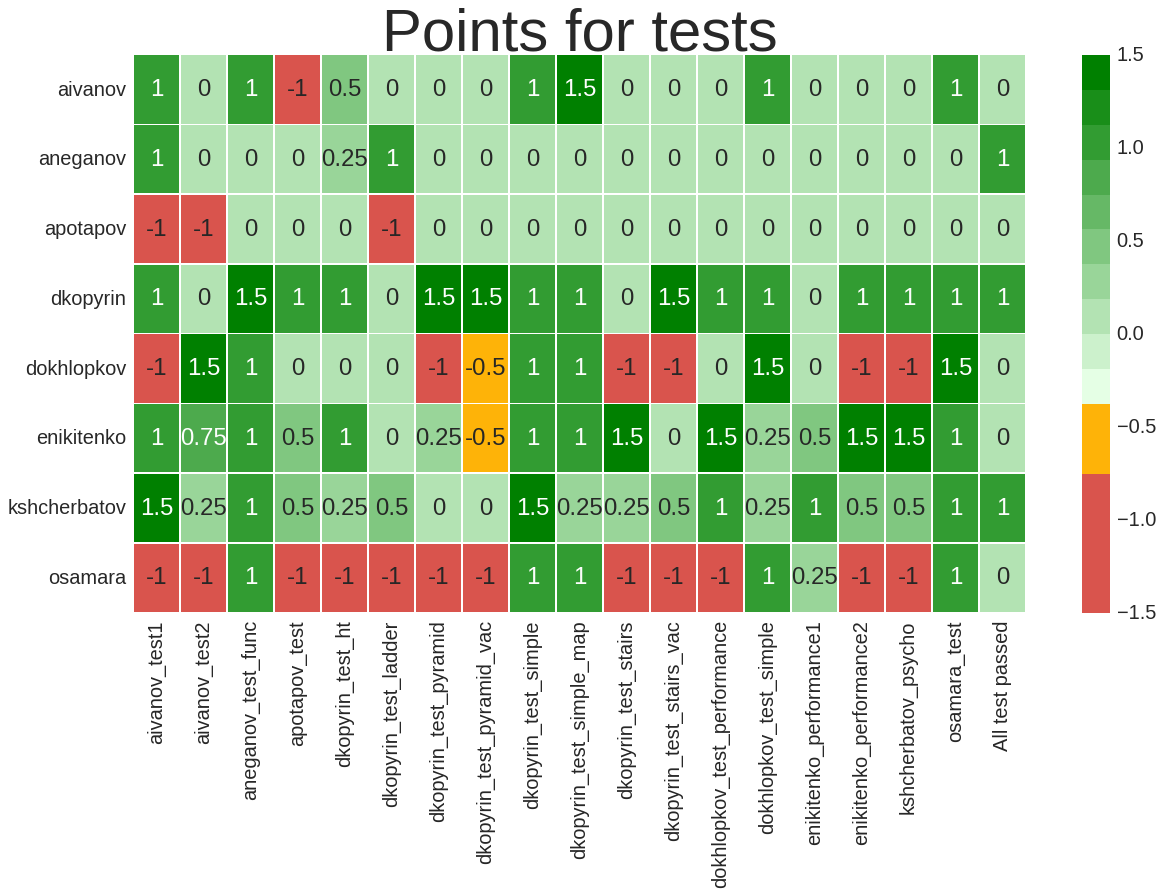

In [8]:
colors = ["pale red", "pale red", "pale red", "pale red", "amber", "amber"]
cmap = matplotlib.colors.ListedColormap(sns.xkcd_palette(colors) + sns.light_palette("green", n_colors=10))

sns.set(font_scale=2)
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
sns.plt.title("Points for tests", fontsize=60)
sns.heatmap(ranks, annot=True, cmap=cmap, center=0, linewidths=.5)
plt.show()

In [9]:
## Code to shift "Test passage" plot to left
from IPython.display import HTML
HTML("""<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('nav#menubar').hide();
  });
</script>
""")

In [10]:
ranks["sum"] = ranks.sum(axis=1)

# for index, row in ranks.iterrows():
#     for test in tests:
#         if row[test] < 0:
#             ranks.set_value(row[test], 'BONUS', 0)

ranks.sort_values(by=['sum'], ascending=False, inplace=True)
# ranks

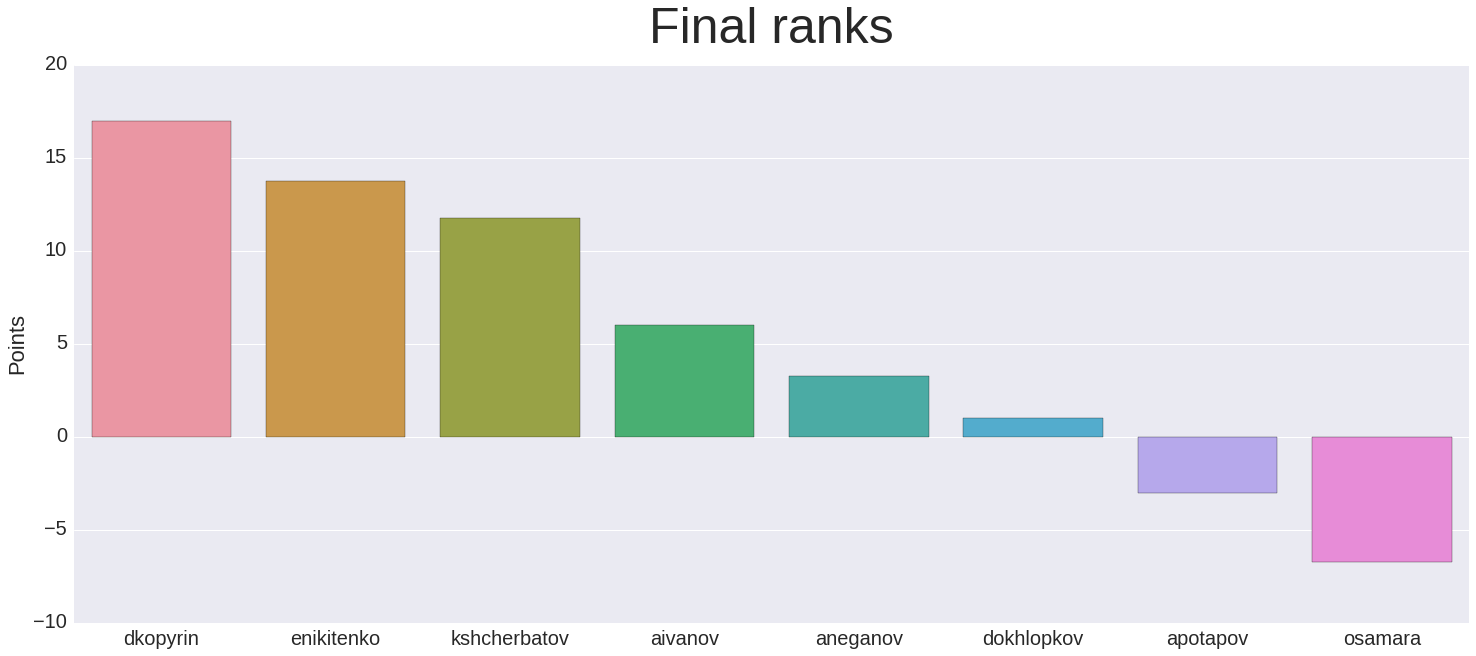

In [11]:
plt.figure(figsize=(25, 10))
sns.set(font_scale=2)
sns.plt.title("Final ranks", fontsize=50, y=1.03)
sns.barplot(y=ranks["sum"], x=ranks.index)
plt.ylabel('Points')
plt.show()

## Results by each test.
There are only libs that passed the test.

In [12]:
# data without timeout values.
passed_data = data[data["mean"] != -1]

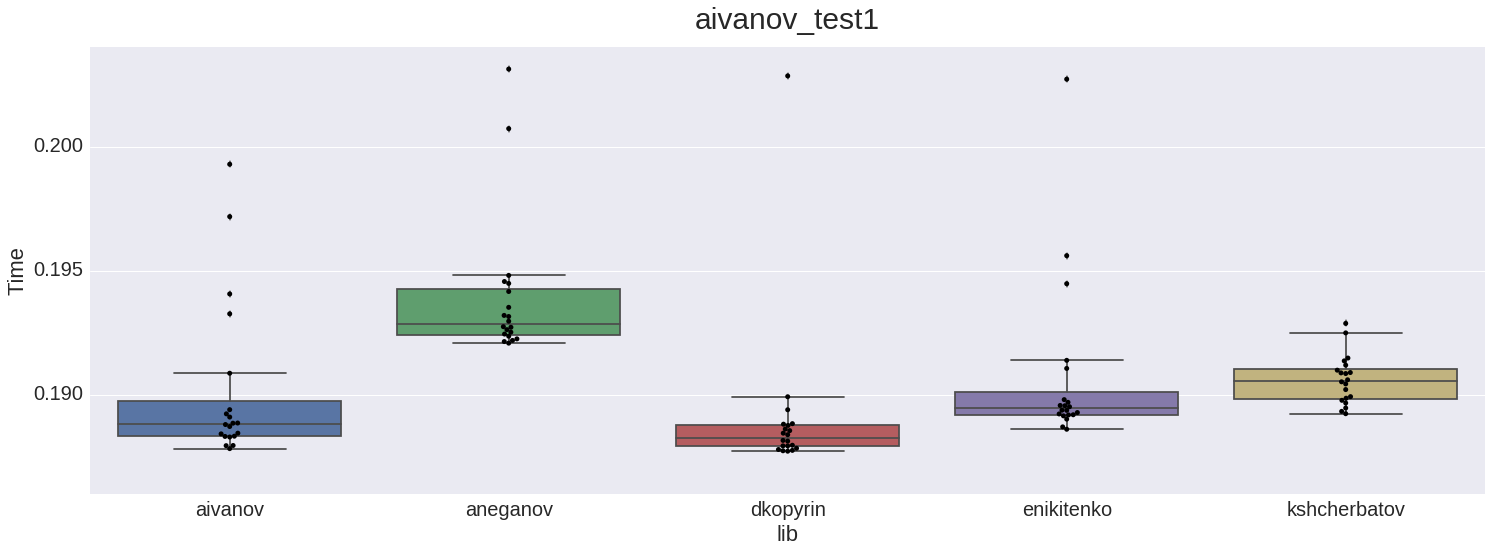

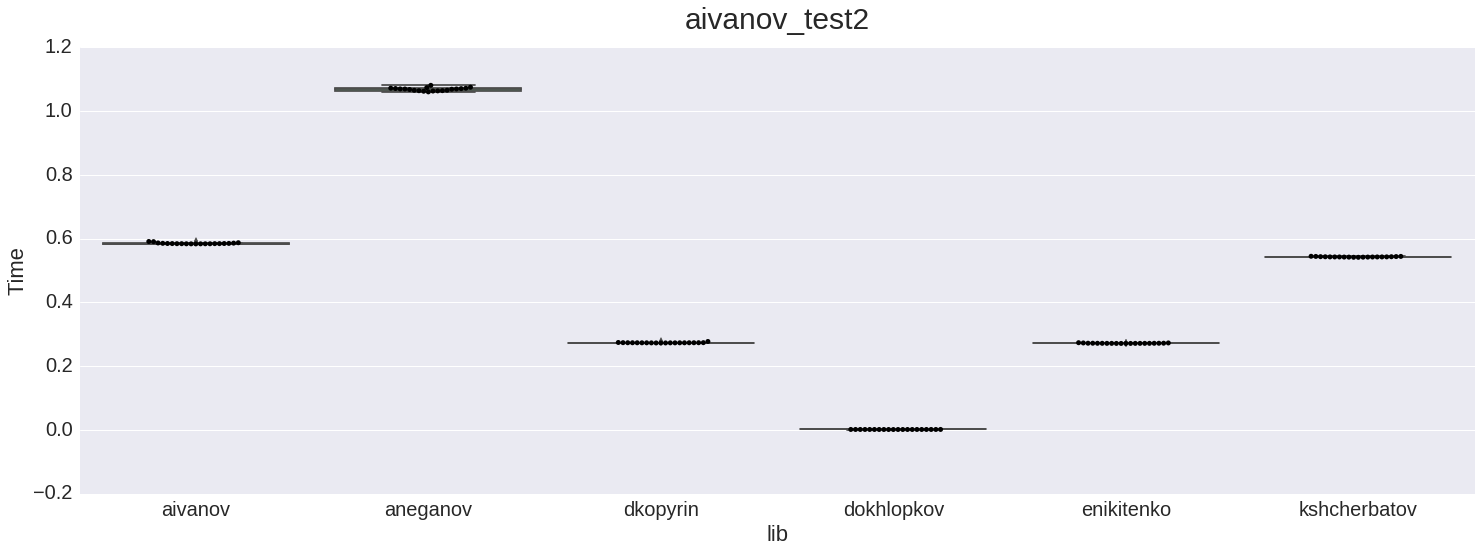

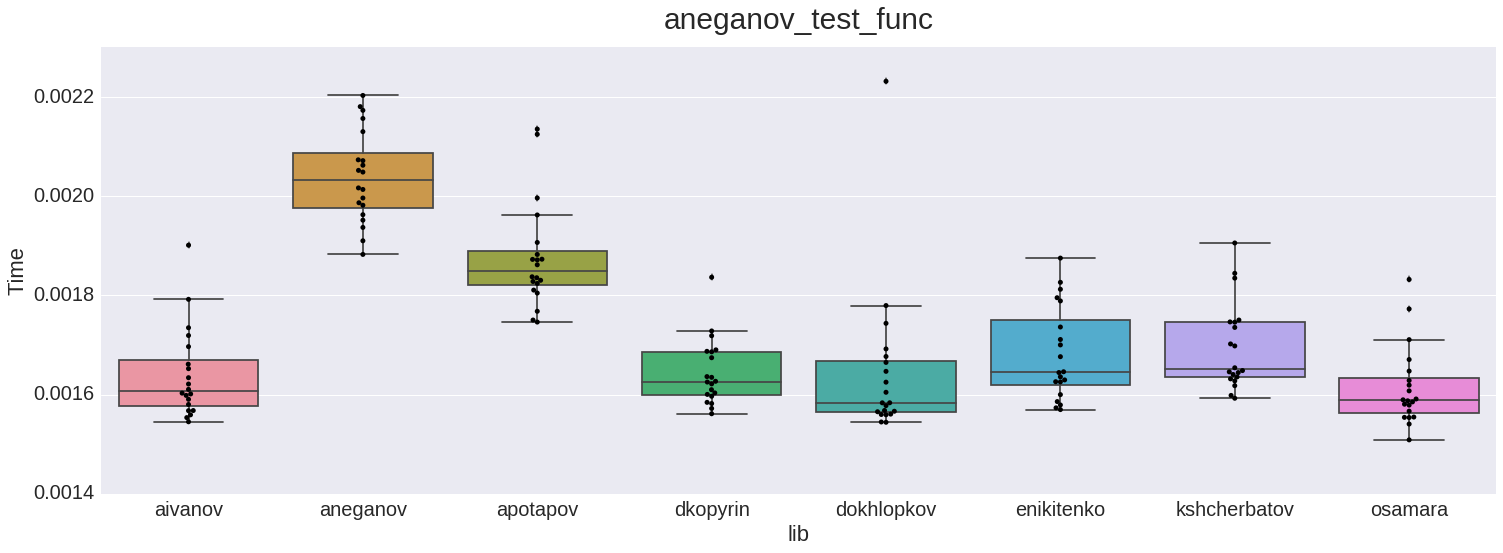

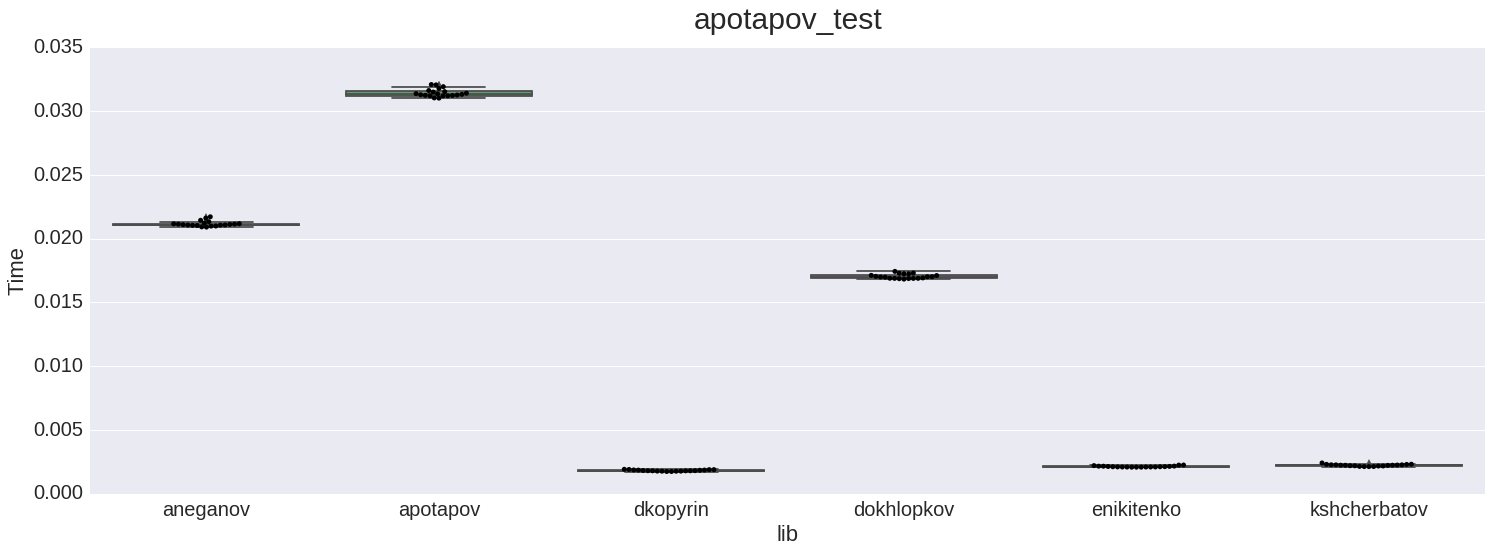

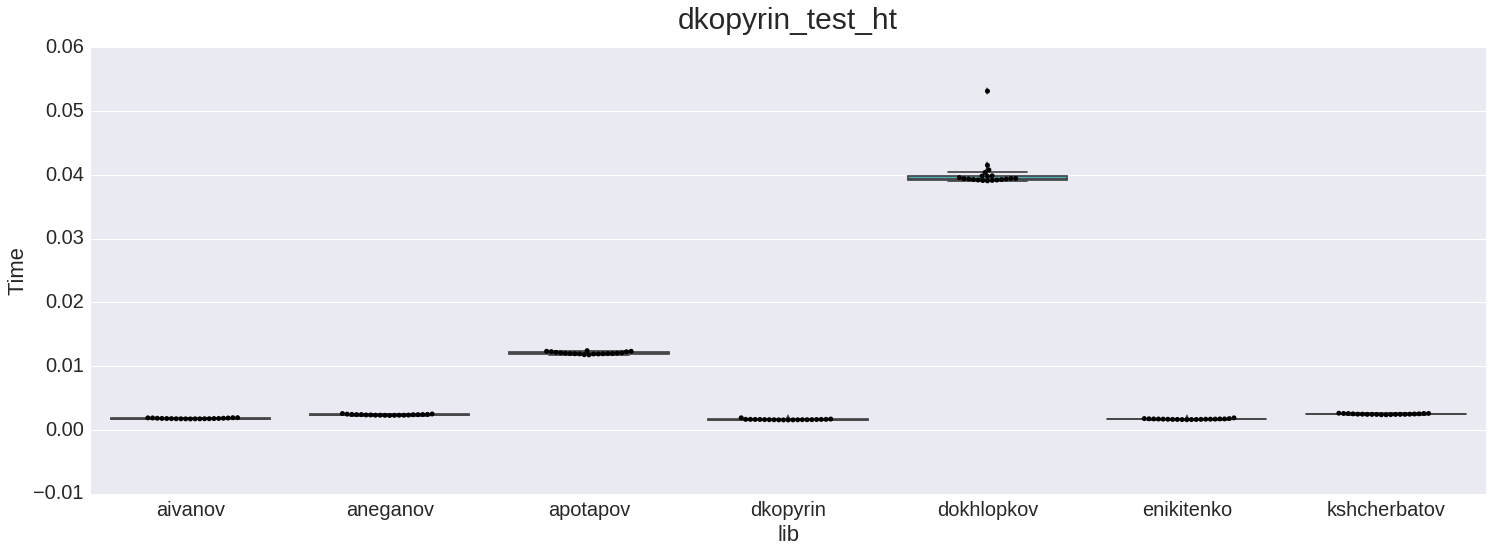

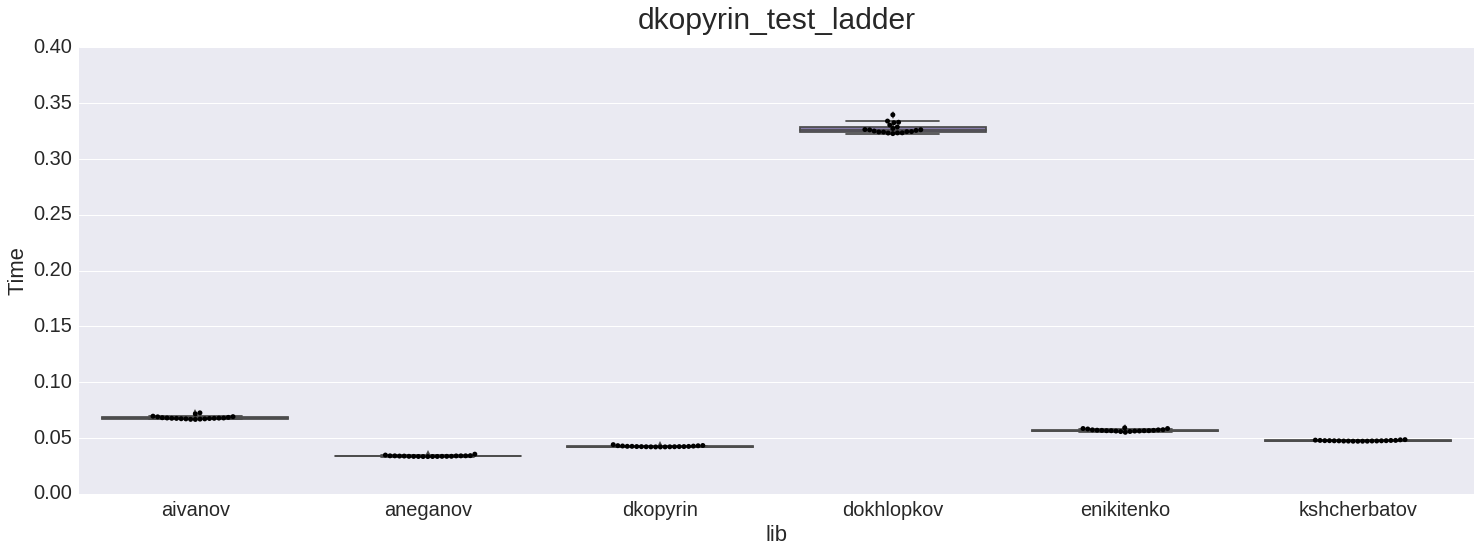

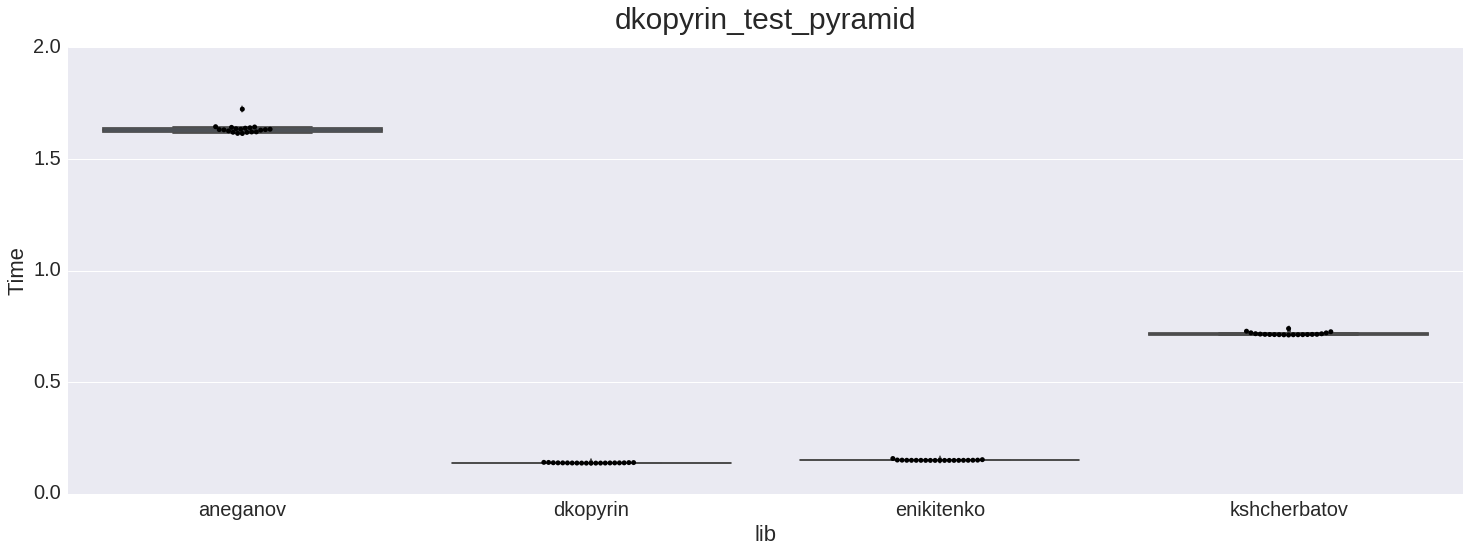

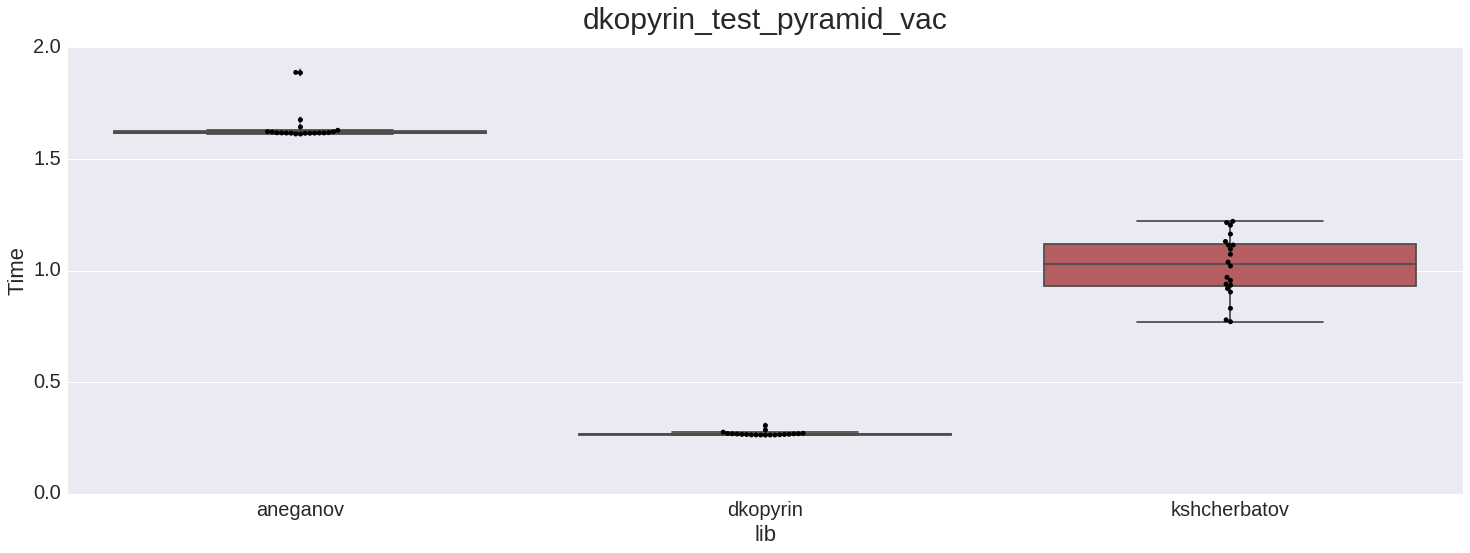

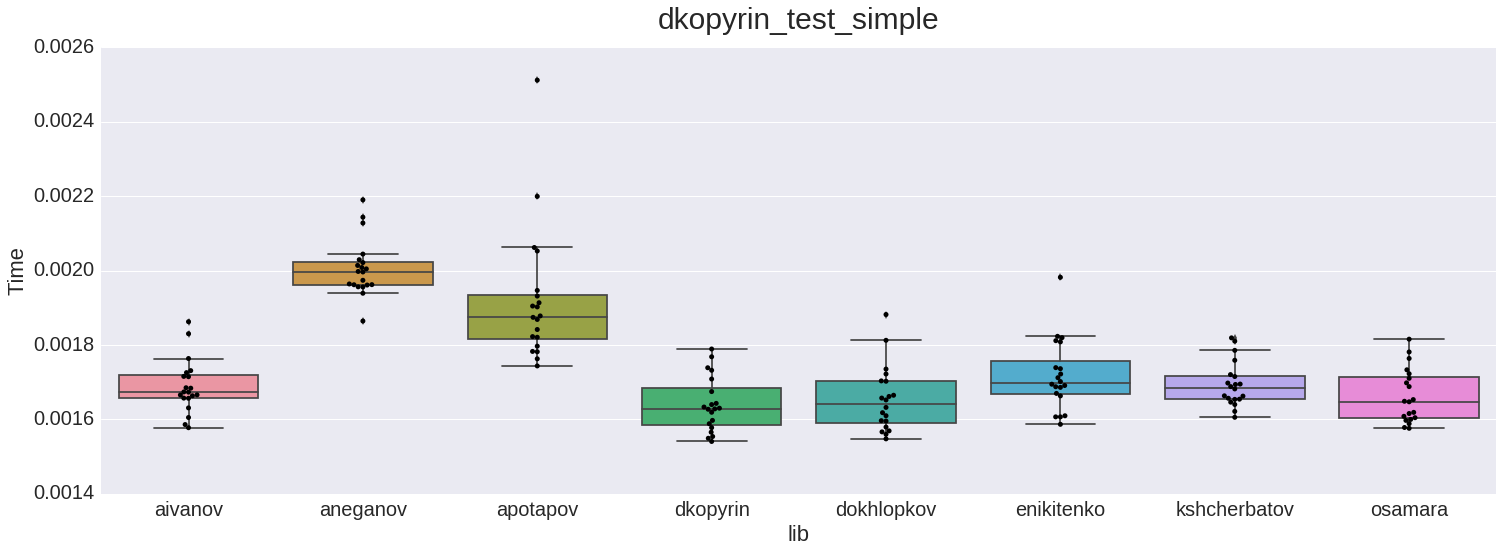

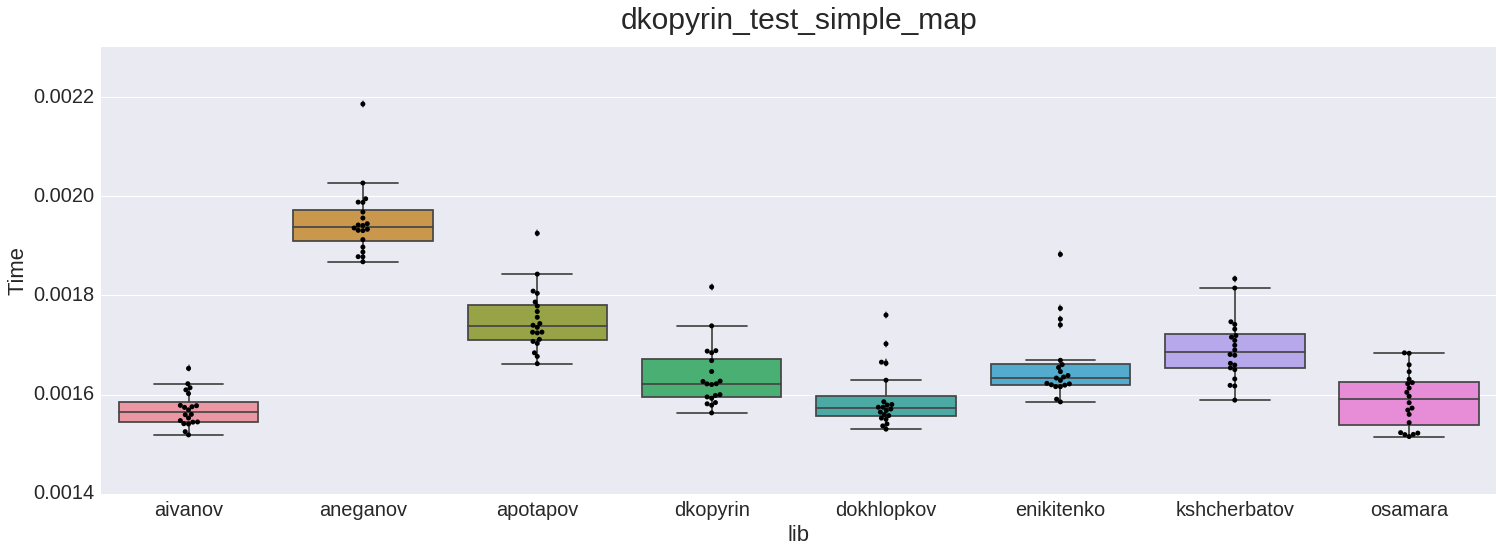

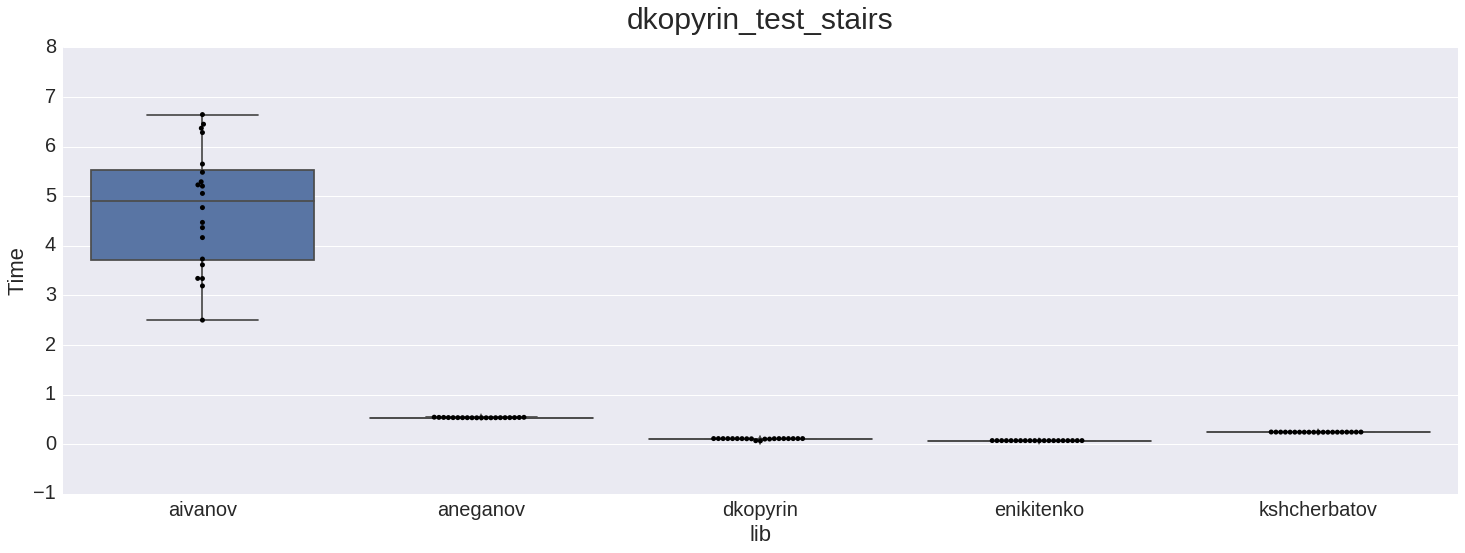

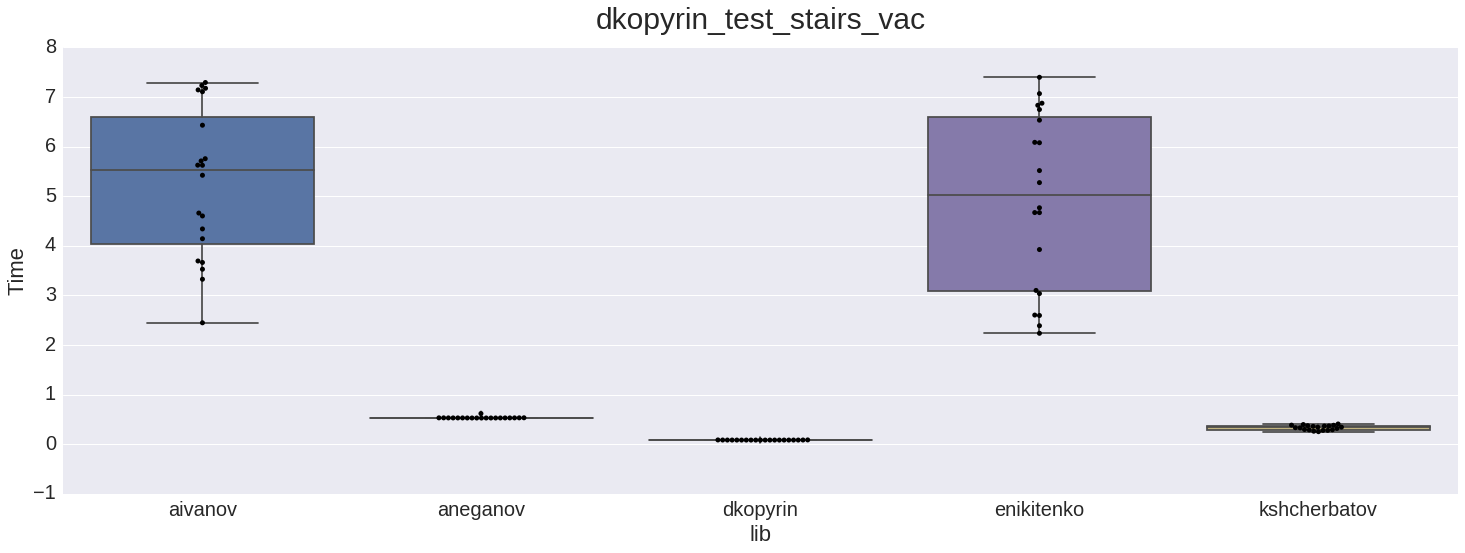

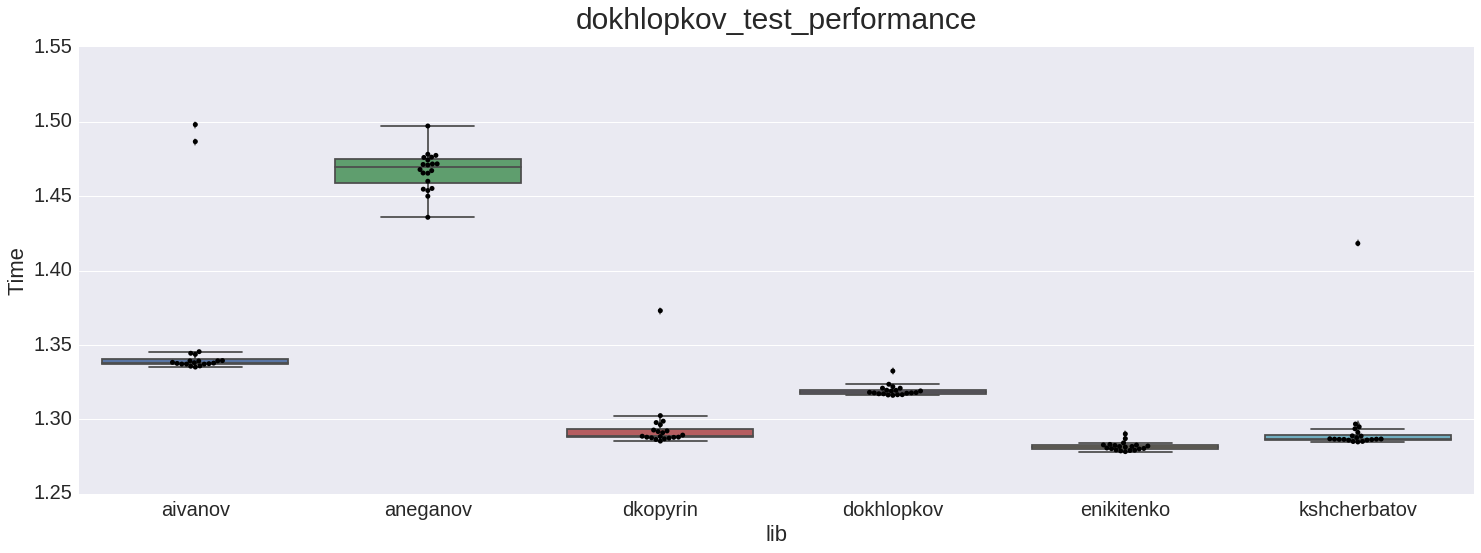

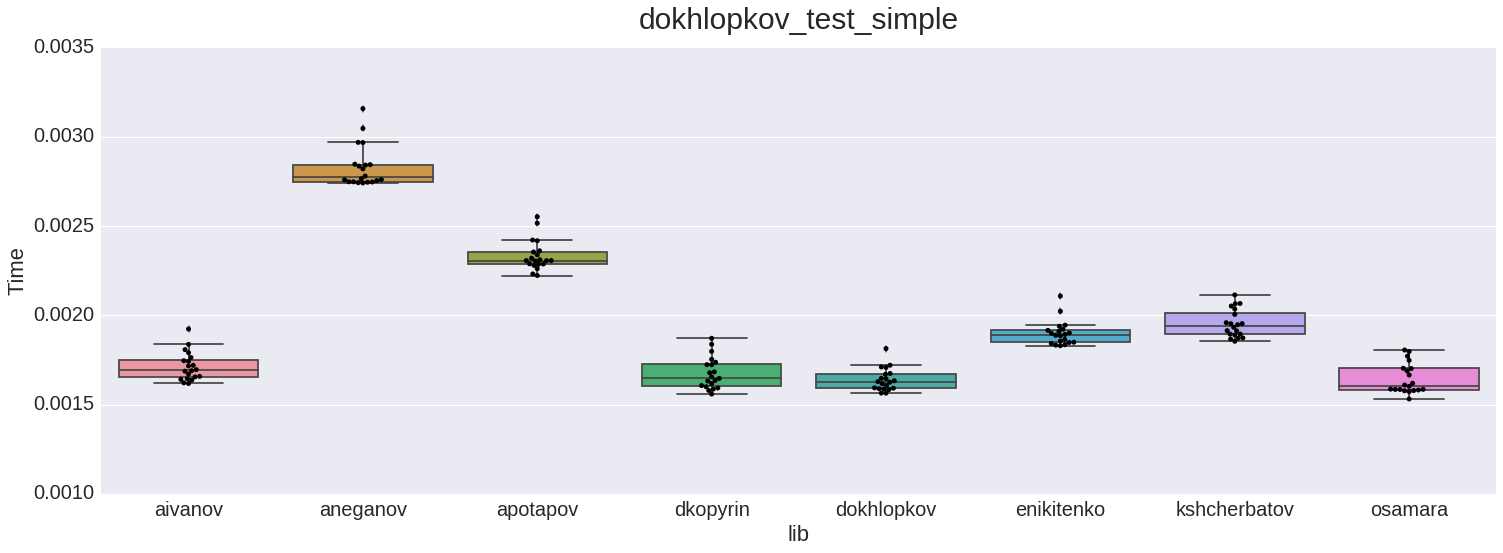

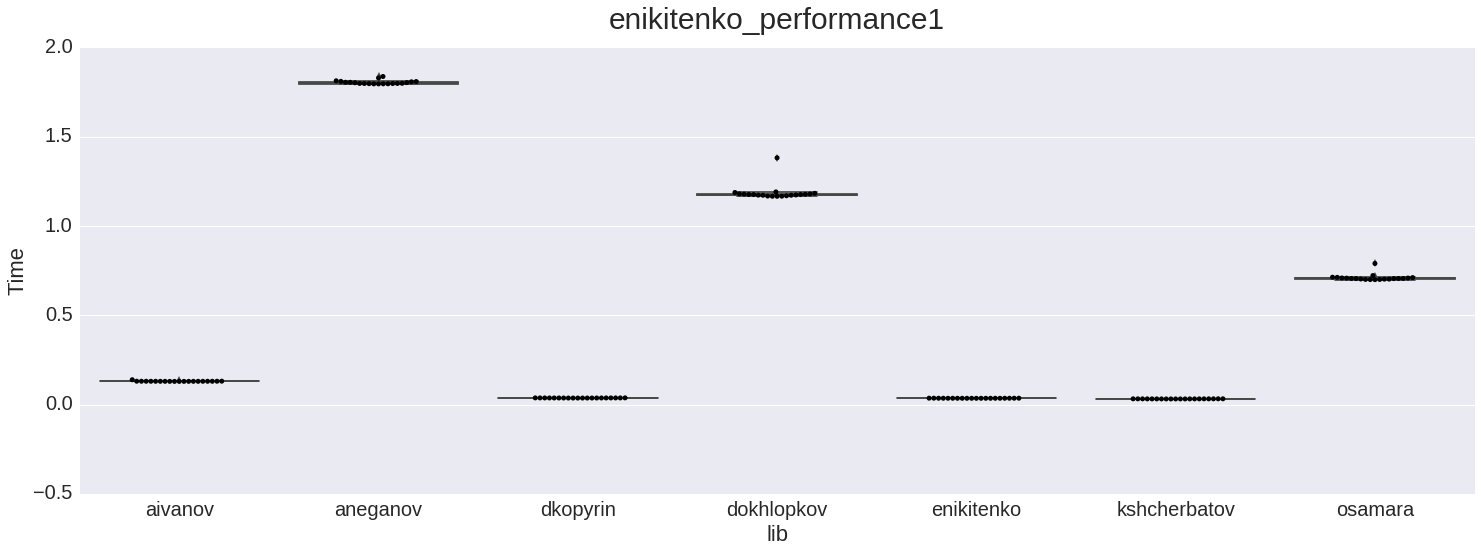

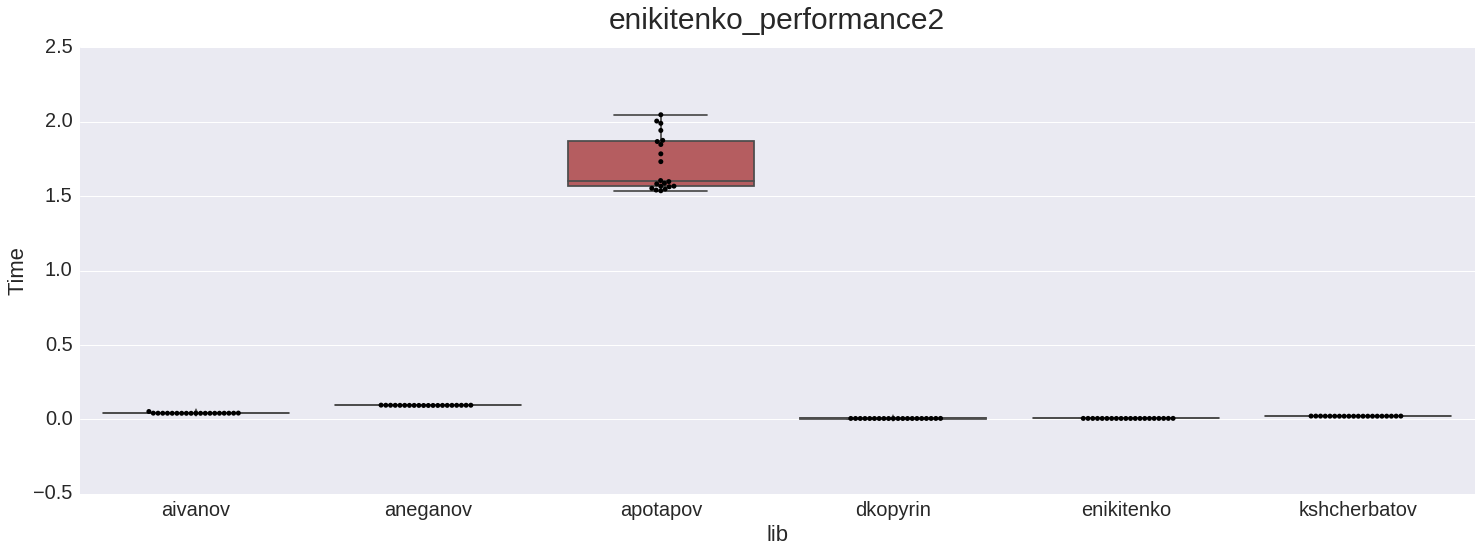

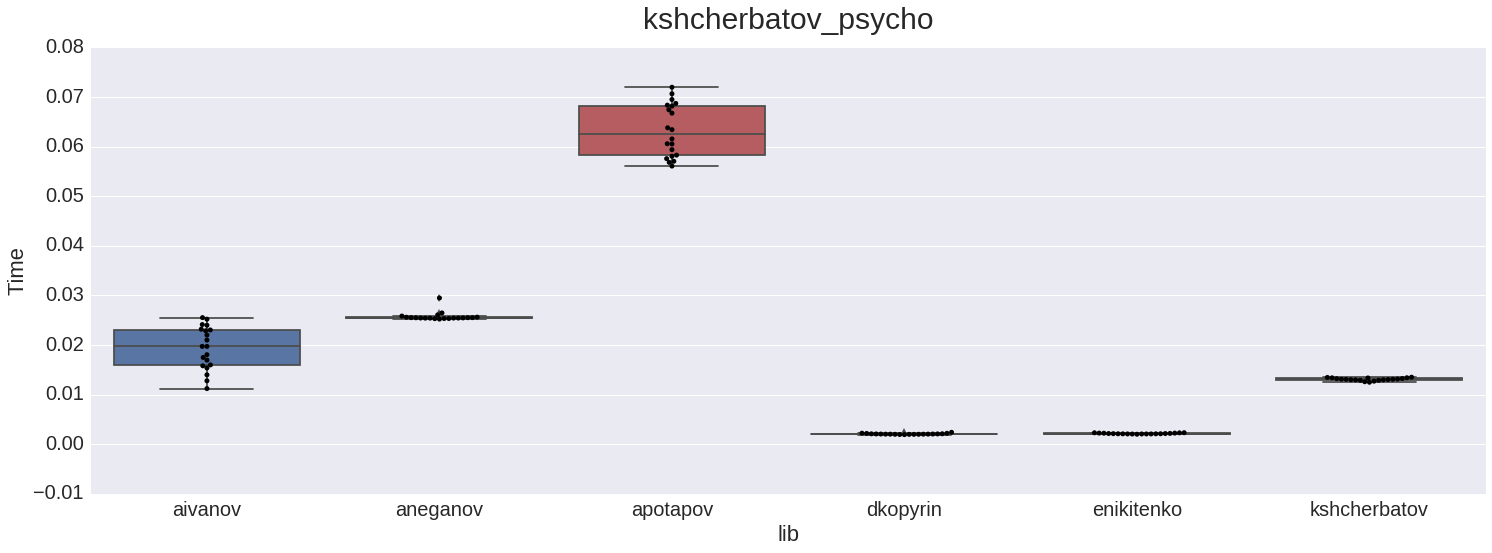

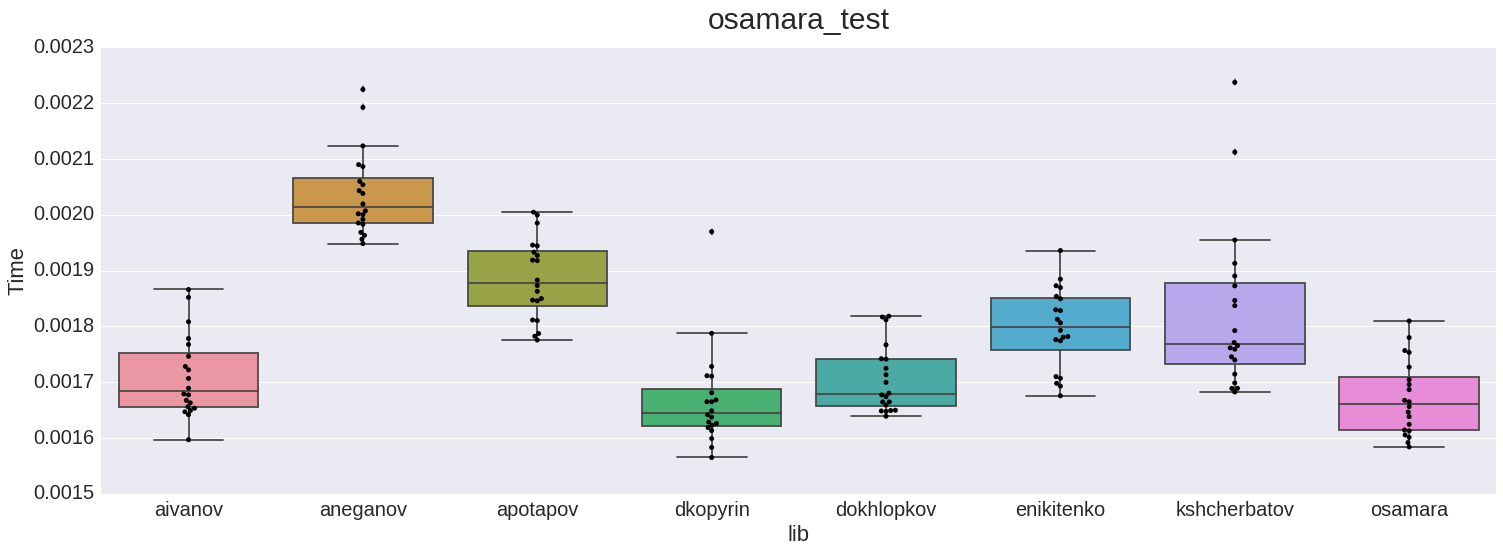

In [13]:
val = passed_data.set_index(passed_data["testid"]).drop(["test", "test_name", "mean", "std", 'testid'], axis=1)
sns.set(font_scale=2)
for test in tests:
    plt.figure(figsize=(25, 8))
    sns.plt.title(test, fontsize=30, y=1.03)
    a = val[val.index == test]
    a = a.set_index(a['lib']).drop(["lib"], axis=1).transpose()
    ax = sns.boxplot(data=a)
    sns.swarmplot(data=a, size=5, ax=ax, color="black")
    plt.ylabel('Time')
    plt.show()

## Raw results 
with mean and std

In [14]:
pd.set_option('display.max_rows', len(data))
data.drop(values, axis=1)

,lib,mean,std,test,test_name,testid
0,aivanov,0.190153,0.003239,aivanov,test1,aivanov_test1
1,aivanov,0.585489,0.002126,aivanov,test2,aivanov_test2
2,aivanov,0.001640,0.000091,aneganov,test_func,aneganov_test_func
3,aivanov,0.001817,0.000063,dkopyrin,test_ht,dkopyrin_test_ht
4,aivanov,0.068213,0.001531,dkopyrin,test_ladder,dkopyrin_test_ladder
5,aivanov,-1.000000,0.000000,dkopyrin,test_pyramid,dkopyrin_test_pyramid
6,aivanov,-1.000000,0.000000,dkopyrin,test_pyramid_vac,dkopyrin_test_pyramid_vac
7,aivanov,0.001688,0.000072,dkopyrin,test_simple,dkopyrin_test_simple
8,aivanov,0.001571,0.000035,dkopyrin,test_simple_map,dkopyrin_test_simple_map
9,aivanov,4.757941,1.213217,dkopyrin,test_stairs,dkopyrin_test_stairs


In [15]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter by dokhlopkov.
</footer>''')